# **SEL-NNML Random Search (RS) Tuning - UCI Cleveland Heart Disease Dataset**

This notebook implements `Stacking Ensemble Learning with a Neural Network Meta-Learner (SEL-NNML)` model on the `UCI Cleveland Heart Disease Dataset (UCHDD)`.

## **0. Global Configuration**

In [1]:
# Random state for reproducibility
RANDOM_STATE = 42

# Data splitting configuration
TEST_SIZE = 0.2

# Cross-validation configuration
CV_FOLDS = 5

# Hyperparameter tuning configuration
OPTIMIZATION_ITERATIONS = 100
OPTIMIZATION_METRIC = 'accuracy'

# Parallel processing configuration
N_JOBS = -1 

# Dataset configuration
DATASET_PATH = '../../datasets/processed/ds2_uci_heart_clean.csv'
TARGET_COLUMN = 'num'

print("Global configuration loaded successfully!")
print(f"Random State: {RANDOM_STATE}")
print(f"Test Size: {TEST_SIZE}")
print(f"CV Folds: {CV_FOLDS}")
print(f"Optimization Iterations: {OPTIMIZATION_ITERATIONS}")
print(f"Optimization Metric: {OPTIMIZATION_METRIC}")

Global configuration loaded successfully!
Random State: 42
Test Size: 0.2
CV Folds: 5
Optimization Iterations: 100
Optimization Metric: accuracy


## **1. Import Library**

In [2]:
import pandas as pd
import numpy as np
np.random.seed(RANDOM_STATE)
import matplotlib.pyplot as plt
import optuna as opt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

## **2. Load Dataset**

In [3]:
df = pd.read_csv(DATASET_PATH)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            297 non-null    int64  
 1   sex            297 non-null    bool   
 2   trestbps       297 non-null    int64  
 3   chol           297 non-null    int64  
 4   fbs            297 non-null    bool   
 5   thalach        297 non-null    int64  
 6   exang          297 non-null    bool   
 7   oldpeak        297 non-null    float64
 8   num            297 non-null    bool   
 9   cp_2           297 non-null    bool   
 10  cp_3           297 non-null    bool   
 11  cp_4           297 non-null    bool   
 12  restecg_1      297 non-null    bool   
 13  restecg_2      297 non-null    bool   
 14  slope_2        297 non-null    bool   
 15  slope_3        297 non-null    bool   
 16  ca_1.0         297 non-null    bool   
 17  ca_2.0         297 non-null    bool   
 18  ca_3.0    

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,num,cp_2,...,restecg_2,slope_2,slope_3,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0,cp_4_thal_7.0,cp_4_exang
0,63,True,145,233,True,150,False,2.3,False,False,...,True,False,True,False,False,False,True,False,False,False
1,67,True,160,286,False,108,True,1.5,True,False,...,True,True,False,False,False,True,False,False,False,True
2,67,True,120,229,False,129,True,2.6,True,False,...,True,True,False,False,True,False,False,True,True,True
3,37,True,130,250,False,187,False,3.5,False,False,...,False,False,True,False,False,False,False,False,False,False
4,41,False,130,204,False,172,False,1.4,False,True,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57,False,140,241,False,123,True,0.2,True,False,...,False,True,False,False,False,False,False,True,True,True
293,45,True,110,264,False,132,False,1.2,True,False,...,False,True,False,False,False,False,False,True,False,False
294,68,True,144,193,True,141,False,3.4,True,False,...,False,True,False,False,True,False,False,True,True,False
295,57,True,130,131,False,115,True,1.2,True,False,...,False,True,False,True,False,False,False,True,True,True


## **3. Data Preparation**

- Split the data into desired training and testing
- After that, Scaling the data using Min-Max Normalization

In [4]:
# Split dataset
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [5]:
# Min-Max Scaling
# Separate numeric and boolean columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
bool_cols = X_train.select_dtypes(include=['bool', 'uint8']).columns  # includes one-hot from get_dummies

# Initialize scaler and fit_transform only on numeric data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index)

# Concatenate back with boolean features (without modification)
X_train = pd.concat([X_train_scaled, X_train[bool_cols]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[bool_cols]], axis=1)

## **4. Base Model Hyperparameter Tuning with RS and Cross Validation**

In [6]:
# Base Model Hyperparameter Tuning with RS and CV Function
def base_model_tuning(model_name, x_train, y_train, iterations=100, metric_compare='accuracy'):
    if model_name == 'Logistic Regression':
        def objective(trial):
            solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'])
            C = trial.suggest_float('C', 1e-4, 10, log=True)
            model = LogisticRegression(solver=solver, C=C, max_iter=1000, random_state=RANDOM_STATE, n_jobs=N_JOBS)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='Random Fine Tuning: Logistic Regression', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = LogisticRegression(**best_params, max_iter=1000, random_state=RANDOM_STATE, n_jobs=N_JOBS)
    
    elif model_name == 'Decision Tree':
        def objective(trial):
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            model = DecisionTreeClassifier(criterion=criterion, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=RANDOM_STATE)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()

        study = opt.create_study(study_name='Random Fine Tuning: Decision Tree', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = DecisionTreeClassifier(**best_params, random_state=RANDOM_STATE)
        
    elif model_name == 'Random Forest':
        def objective(trial):
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
            n_estimators = trial.suggest_int('n_estimators', 10, 100)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            model = RandomForestClassifier(criterion=criterion, max_features=max_features, n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=RANDOM_STATE, n_jobs=N_JOBS)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='Random Fine Tuning: Random Forest', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=N_JOBS)
    
    elif model_name == 'K-Nearest Neighbors':
        def objective(trial):
            algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree', 'brute'])
            n_neighbors = trial.suggest_int('n_neighbors', 3, 50)
            p = trial.suggest_int('p', 1, 2)
            model = KNeighborsClassifier(weights='uniform', algorithm=algorithm, n_neighbors=n_neighbors, p=p, n_jobs=N_JOBS)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='Random Fine Tuning: K-Nearest Neighbors', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = KNeighborsClassifier(**best_params, weights='uniform', n_jobs=N_JOBS)
    
    elif model_name == 'Support Vector Machine':
        def objective(trial):
            kernel = trial.suggest_categorical('kernel', ['rbf', 'sigmoid', 'poly'])
            C = trial.suggest_float('C', 1e-4, 1e-2, log=True)
            degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
            model = SVC(kernel=kernel, gamma='scale', C=C, degree=degree, random_state=RANDOM_STATE)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='Random Fine Tuning: Support Vector Machine', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = SVC(**best_params, gamma='scale', random_state=RANDOM_STATE)
    
    elif model_name == 'AdaBoost':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 10, 100)
            learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0, log=True)
            model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=RANDOM_STATE)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='Random Fine Tuning: AdaBoost', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = AdaBoostClassifier(**best_params, random_state=RANDOM_STATE)
        
    elif model_name == 'Gradient Boosting':
        def objective(trial):
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
            n_estimators = trial.suggest_int('n_estimators', 10, 100)
            learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            subsample = trial.suggest_float('subsample', 0.5, 1.0)
            model = GradientBoostingClassifier(criterion='friedman_mse', loss='log_loss', max_features=max_features, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=RANDOM_STATE)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='Random Fine Tuning: Gradient Boosting', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = GradientBoostingClassifier(**best_params, criterion='friedman_mse', loss='log_loss', random_state=RANDOM_STATE)
    
    print(f'\nBest Hyperparameters for {model_name}: (Using RandomSampler)')
    print(best_params)
    
    return model

In [7]:
# Begin timing base models training
base_models_training_start = time.time()

### **4.1 Logistic Regression Hyperparameter Tuning**

In [8]:
logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:48:47,726] A new study created in memory with name: Random Fine Tuning: Logistic Regression


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:48:51,301] Trial 0 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.52322695035461.
[I 2025-10-02 22:48:53,405] Trial 1 finished with value: 0.8268617021276595 and parameters: {'solver': 'newton-cholesky', 'C': 0.3470266988650412}. Best is trial 1 with value: 0.8268617021276595.
[I 2025-10-02 22:48:55,550] Trial 2 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0008111941985431928}. Best is trial 1 with value: 0.8268617021276595.
[I 2025-10-02 22:48:57,555] Trial 3 finished with value: 0.763563829787234 and parameters: {'solver': 'newton-cholesky', 'C': 0.0028585493941961923}. Best is trial 1 with value: 0.8268617021276595.
[I 2025-10-02 22:48:57,595] Trial 4 finished with value: 0.8056737588652483 and parameters: {'solver': 'lbfgs', 'C': 0.019069966103000432}. Best is trial 1 with value: 0.8268617021276595.
[I 2025-10-02 22:48:57,632] Trial 5 fi

### **4.2 Decision Tree Hyperparameter Tuning**

In [9]:
decision_tree = base_model_tuning('Decision Tree', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:49:01,221] A new study created in memory with name: Random Fine Tuning: Decision Tree


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:49:01,338] Trial 0 finished with value: 0.7085992907801418 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7085992907801418.
[I 2025-10-02 22:49:01,419] Trial 1 finished with value: 0.7042553191489361 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7085992907801418.
[I 2025-10-02 22:49:01,496] Trial 2 finished with value: 0.7000886524822695 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7085992907801418.
[I 2025-10-02 22:49:01,578] Trial 3 finished with value: 0.737854609929078 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.73785

### **4.3 Random Forest Hyperparameter Tuning**

In [10]:
random_forest = base_model_tuning('Random Forest', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:49:03,408] A new study created in memory with name: Random Fine Tuning: Random Forest


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:49:03,538] Trial 0 finished with value: 0.7676418439716313 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7676418439716313.
[I 2025-10-02 22:49:03,692] Trial 1 finished with value: 0.801241134751773 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.801241134751773.
[I 2025-10-02 22:49:03,843] Trial 2 finished with value: 0.7251773049645389 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.801241134751773.
[I 2025-10-02 22:49:03,995] Trial 3 finished with value: 0.7928191489361702 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples_sp

### **4.4 K-Nearest Neighbors Hyperparameter Tuning**

In [11]:
knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:49:17,448] A new study created in memory with name: Random Fine Tuning: K-Nearest Neighbors


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:49:17,504] Trial 0 finished with value: 0.7930851063829787 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.7930851063829787.
[I 2025-10-02 22:49:17,666] Trial 1 finished with value: 0.7973404255319149 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 1 with value: 0.7973404255319149.
[I 2025-10-02 22:49:17,715] Trial 2 finished with value: 0.788918439716312 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 1 with value: 0.7973404255319149.
[I 2025-10-02 22:49:17,855] Trial 3 finished with value: 0.7764184397163121 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 1}. Best is trial 1 with value: 0.7973404255319149.
[I 2025-10-02 22:49:17,892] Trial 4 finished with value: 0.7890070921985816 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1}. Best is trial 1 with value: 0.7973404255319149.
[I 2025-10-02 22:49:17,938] Trial 5 fi

### **4.5 Support Vector Machine Hyperparameter Tuning**

In [12]:
svm = base_model_tuning('Support Vector Machine', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:49:21,880] A new study created in memory with name: Random Fine Tuning: Support Vector Machine


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:49:21,917] Trial 0 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.52322695035461.
[I 2025-10-02 22:49:21,944] Trial 1 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.005399484409787433}. Best is trial 0 with value: 0.52322695035461.
[I 2025-10-02 22:49:21,974] Trial 2 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.008706020878304856}. Best is trial 0 with value: 0.52322695035461.
[I 2025-10-02 22:49:22,001] Trial 3 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00023270677083837802}. Best is trial 0 with value: 0.52322695035461.
[I 2025-10-02 22:49:22,031] Trial 4 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0003823475224675188}. Best is trial 0 with value: 0.52322695035461.
[I 2025-10-02 22:49:22,057] Trial 5 finished with value: 0.52322695035461 

### **4.6 Adaptive Boosting Hyperparameter Tuning**

In [13]:
adaboost = base_model_tuning('AdaBoost', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:49:24,111] A new study created in memory with name: Random Fine Tuning: AdaBoost


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:49:24,208] Trial 0 finished with value: 0.8139184397163121 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8139184397163121.
[I 2025-10-02 22:49:24,338] Trial 1 finished with value: 0.7675531914893616 and parameters: {'n_estimators': 76, 'learning_rate': 0.06251373574521749}. Best is trial 0 with value: 0.8139184397163121.
[I 2025-10-02 22:49:24,387] Trial 2 finished with value: 0.7168439716312056 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029375384576328283}. Best is trial 0 with value: 0.8139184397163121.
[I 2025-10-02 22:49:24,434] Trial 3 finished with value: 0.7717198581560284 and parameters: {'n_estimators': 15, 'learning_rate': 0.39676050770529875}. Best is trial 0 with value: 0.8139184397163121.
[I 2025-10-02 22:49:24,543] Trial 4 finished with value: 0.7716312056737589 and parameters: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}. Best is trial 0 with value: 0.8139184397163121.


### **4.7 Gradient Boosting Hyperparameter Tuning**

In [14]:
gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:49:33,689] A new study created in memory with name: Random Fine Tuning: Gradient Boosting


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:49:33,815] Trial 0 finished with value: 0.7592198581560284 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.7592198581560284.
[I 2025-10-02 22:49:33,968] Trial 1 finished with value: 0.7420212765957447 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.762378215816119}. Best is trial 0 with value: 0.7592198581560284.
[I 2025-10-02 22:49:34,017] Trial 2 finished with value: 0.725531914893617 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.00383962929980417, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5998368910791798}. Best is trial 0 with value: 0.7592198581560284.
[I 2025-10-02 22:49:34,087] Trial 3 finish

### **4.8 Save Best Model for each Base Models**

In [15]:
# Final Base Model Fitting
base_logistic_regression = logistic_regression.fit(X_train, y_train)
base_decision_tree = decision_tree.fit(X_train, y_train)
base_random_forest = random_forest.fit(X_train, y_train)
base_knn = knn.fit(X_train, y_train)
base_svm = svm.fit(X_train, y_train)
base_adaboost = adaboost.fit(X_train, y_train)
base_gradient_boosting = gradient_boosting.fit(X_train, y_train)

# End timing base models training
base_models_training_end = time.time()

# Save base models total training time
base_models_training_time = base_models_training_end - base_models_training_start

# Base Models Storage
base_models = {
    'Logistic Regression': base_logistic_regression,
    'Decision Tree': base_decision_tree,
    'Random Forest': base_random_forest,
    'K-Nearest Neighbors': base_knn,
    'Support Vector Machine': base_svm,
    'AdaBoost': base_adaboost,
    'Gradient Boosting': base_gradient_boosting
}

# Show Base Model Hyperparameters
base_model_hyperparameters = pd.DataFrame(columns=['Model Name', 'Best Hyperparameters'])
base_model_hyperparameters['Model Name'] = [
                                        'Logistic Regression', 
                                        'Decision Tree', 
                                        'Random Forest', 
                                        'K-Nearest Neighbors', 
                                        'Support Vector Machine', 
                                        'AdaBoost', 
                                        'Gradient Boosting'
                                        ]
base_model_hyperparameters['Best Hyperparameters'] = [   
                                                base_logistic_regression.get_params(),
                                                base_decision_tree.get_params(), 
                                                base_random_forest.get_params(), 
                                                base_knn.get_params(), 
                                                base_svm.get_params(), 
                                                base_adaboost.get_params(), 
                                                base_gradient_boosting.get_params(),
                                                ]

base_model_hyperparameters

,Model Name,Best Hyperparameters
0,Logistic Regression,"{'C': 1.7624510039685515, 'class_weight': None..."
1,Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
2,Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
3,K-Nearest Neighbors,"{'algorithm': 'brute', 'leaf_size': 30, 'metri..."
4,Support Vector Machine,"{'C': 0.008088298191148204, 'break_ties': Fals..."
5,AdaBoost,"{'algorithm': 'deprecated', 'estimator': None,..."
6,Gradient Boosting,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."


## **5. Meta Model Hyperparameter Tuning with RS and Cross Validation**

The hyperparameters to be tuned are:
- Selection of the number and type of base models used
- Number of layers in the neural network: 1 - 5
- Number of neurons per layer: 10 - 100
- Learning rate behavior: Constant or Adaptive
- Learning rate value: 0.0001 - 0.01
- L2 Regularization value: 0.0001 - 0.01

Unchanged Preset hyperparameters:
- Activation function: ReLU
- Optimizer (Solver): Adam
- Epochs (Max Iter): 300

In [16]:
# Meta Model (Stacking with MLP) Hyperparameter Tuning with RS and CV Function
def meta_model_tuning(models, x_train, y_train, x_test, y_test, iterations=100):
    def objective(trial):
        # Suggest which base models to include
        selected_estimators = []
        for name, model in models.items():
            use_model = trial.suggest_categorical(f'use_{name}', [True, False])
            if use_model:
                selected_estimators.append((name, model))
        # At least 2 base models required for stacking
        if len(selected_estimators) < 2:
            return 0.0

        n_layers = trial.suggest_int('n_layers', 1, 5)
        neurons = [trial.suggest_int(f'n_neurons_{i}', 10, 100) for i in range(n_layers)]
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
        learning_rate_init = trial.suggest_float('learning_rate_init', 0.0001, 0.01, log=True)
        alpha = trial.suggest_float('alpha', 0.0001, 0.01, log=True)

        meta_model = MLPClassifier(
            activation='relu',
            solver='adam',
            hidden_layer_sizes=tuple(neurons),
            learning_rate=learning_rate,
            learning_rate_init=learning_rate_init,
            alpha=alpha,
            max_iter=300,
            random_state=RANDOM_STATE
        )

        stacking_model = StackingClassifier(
            estimators=selected_estimators,
            final_estimator=meta_model,
            cv=CV_FOLDS,
            n_jobs=N_JOBS
        )

        stacking_model.fit(x_train, y_train)
        y_pred = stacking_model.predict(x_test)
        return accuracy_score(y_test, y_pred)

    study = opt.create_study(study_name='Meta Model Fine Tuning: Stacking with MLP (Random Search)', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
    study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
    best_params = study.best_params

    # Get selected estimators from best_params
    best_selected_estimators = []
    for name, model in models.items():
        if best_params.get(f'use_{name}', False):
            best_selected_estimators.append((name, model))
            
    n_layers = best_params.pop('n_layers')
    hidden_layer_sizes = tuple(best_params.pop(f'n_neurons_{i}') for i in range(n_layers))
    best_params['hidden_layer_sizes'] = hidden_layer_sizes

    # Define the final meta model
    mlp_params = {k: v for k, v in best_params.items() if not k.startswith('use_')}
    best_meta_model = MLPClassifier(**mlp_params, activation='relu', solver='adam', max_iter=300, random_state=RANDOM_STATE)

    # Create the final stacking model using best_selected_estimators
    best_stacking_model = StackingClassifier(estimators=best_selected_estimators, final_estimator=best_meta_model, cv=CV_FOLDS, n_jobs=N_JOBS)

    print('\nBest Meta Model Hyperparameters:')
    print(best_meta_model.get_params())
    print('\nSelected Base Models for Stacking:')
    for name, _ in best_selected_estimators:
        print(f'- {name}')

    return best_stacking_model

In [17]:
# Begin timing meta model training
meta_model_training_start = time.time()

# Meta Model Tuning and Final Stacking Model Fitting
sel_nnml = meta_model_tuning(base_models, X_train, y_train, X_test, y_test, iterations=OPTIMIZATION_ITERATIONS)
sel_nnml.fit(X_train, y_train)

# End timing meta model training
meta_model_training_end = time.time()

# Save meta model training time
meta_model_training_time = meta_model_training_end - meta_model_training_start

[I 2025-10-02 22:49:43,844] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (Random Search)


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:49:44,604] Trial 0 finished with value: 0.8333333333333334 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.8333333333333334.
[I 2025-10-02 22:49:45,881] Trial 1 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 37, 'n_neurons_2': 18, 'n_neurons_3': 72, 'n_neurons_4': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[I 2025-10-02 22:49:51,214] Trial 2 finished with value: 0.85 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.004544383960336014, 'alpha': 0.0005170191786366995}. Best is trial 1 with value: 0.9166666666666666.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:49:51,949] Trial 3 finished with value: 0.85 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 20, 'n_neurons_1': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00013400367243354819, 'alpha': 0.0004187594718900631}. Best is trial 1 with value: 0.9166666666666666.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:49:52,670] Trial 4 finished with value: 0.8333333333333334 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0010402587615883842, 'alpha': 0.006533305220227739}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:49:53,680] Trial 5 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 83, 'n_neurons_1': 91, 'n_neurons_2': 38, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007148510793512986, 'alpha': 0.00432543242796456}. Best is trial 1 with v

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:49:59,977] Trial 15 finished with value: 0.85 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 65, 'n_neurons_1': 48, 'n_neurons_2': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010685306331940677, 'alpha': 0.00017066532063900338}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:00,830] Trial 16 finished with value: 0.85 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 66, 'n_neurons_1': 55, 'learning_rate': 'constant', 'learning_rate_init': 0.0002117721540886054, 'alpha': 0.00013840044764106221}. Best is trial 1 with value:

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:50:05,887] Trial 23 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 27, 'n_neurons_1': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00014304387745680657, 'alpha': 0.008887704677237365}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:07,021] Trial 24 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 14, 'n_neurons_1': 12, 'n_neurons_2': 44, 'n_neurons_3': 83, 'n_neurons_4': 99, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005778055555902347, 'alpha': 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:50:07,916] Trial 25 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 50, 'n_neurons_1': 21, 'learning_rate': 'constant', 'learning_rate_init': 0.00028660621978595627, 'alpha': 0.0022049633175740767}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:08,696] Trial 26 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 74, 'n_neurons_2': 29, 'n_neurons_3': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0015129876174918638, 'alpha': 0.0006

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:50:11,721] Trial 30 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 58, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007299936670144685, 'alpha': 0.000179953627507624}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:12,572] Trial 31 finished with value: 0.8333333333333334 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 91, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006619019399921065, 'alpha': 0.009220558632540494}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-1

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:50:18,341] Trial 39 finished with value: 0.8166666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 67, 'n_neurons_1': 11, 'n_neurons_2': 70, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00019830125168914512, 'alpha': 0.0006749137054804921}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:19,112] Trial 40 finished with value: 0.8333333333333334 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 51, 'n_neurons_1': 57, 'n_neurons_2': 50, 'n_neurons_3': 46, 'learning_rate': 'constant', 'learning_rate_init': 0.0002311299689

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:50:19,855] Trial 41 finished with value: 0.8333333333333334 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000299478439928207, 'alpha': 0.00015808213238348277}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:20,053] Trial 42 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 48, 'n_neurons_1': 91, 'n_neurons_2': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.0005746253963762425, 'alpha': 0.0015156184556529744}. Best is trial 1 wi

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:50:20,801] Trial 43 finished with value: 0.85 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003279256370202935, 'alpha': 0.00018998186562844776}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:21,501] Trial 44 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 22, 'learning_rate': 'constant', 'learning_rate_init': 0.001566124214205962, 'alpha': 0.001588670096363}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:22,287] 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:50:25,682] Trial 50 finished with value: 0.8333333333333334 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 29, 'learning_rate': 'constant', 'learning_rate_init': 0.00015094613753824642, 'alpha': 0.0006841661003247827}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:26,490] Trial 51 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.008673717241575788, 'alpha': 0.00585560495923566}. Best is trial 1 with value: 0.91666666666

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:50:41,823] Trial 75 finished with value: 0.85 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 19, 'learning_rate': 'constant', 'learning_rate_init': 0.0003534445856055918, 'alpha': 0.0001441579965339067}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:41,829] Trial 76 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:42,541] Trial 77 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Ne

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:50:49,395] Trial 85 finished with value: 0.7 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.00011012601445612862, 'alpha': 0.0001459967993464517}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:50,162] Trial 86 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 99, 'n_neurons_1': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.004202808250827565, 'alpha': 0.0020556880660352003}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:50,

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:50:56,539] Trial 96 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 32, 'n_neurons_1': 87, 'learning_rate': 'constant', 'learning_rate_init': 0.00016964370300905638, 'alpha': 0.005251451836209499}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-10-02 22:50:57,363] Trial 97 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 15, 'n_neurons_1': 56, 'n_neurons_2': 83, 'learning_rate': 'constant', 'learning_rate_init': 0.0037372865574134733, 'alpha': 0.00025277118490608436}. Best is trial 

In [18]:
# All Models Storage (including Stacking Model)
all_models = {
    'Logistic Regression': base_logistic_regression,
    'Decision Tree': base_decision_tree,
    'Random Forest': base_random_forest,
    'K-Nearest Neighbors': base_knn,
    'Support Vector Machine': base_svm,
    'AdaBoost': base_adaboost,
    'Gradient Boosting': base_gradient_boosting,
    'SEL-NNML': sel_nnml
}

## **6. Model Evaluation**

This stage contains model evaluation on the test set, with details as follows:
- `plot_evaluation_metrics()`: Shows the confusion matrix graph & scores for accuracy, precision, recall, and F1-Score
- `Model Performance Comparison Plot`: Displays accuracy, precision, recall, F1-Score, and ROC AUC scores
- `overfitting_index_plot()`: Shows the percentage of the difference between model scores on test data versus training data

In [19]:
# Single Model Evaluation Dashboard
def evaluation_metrics_plot(y_true, y_pred):
    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
    }
    metric_order = ['F1-Score', 'Recall', 'Precision', 'Accuracy']
    values = [metrics[name] for name in metric_order]

    fig = plt.figure(figsize=(10, 8))
    cm_pos = [0.08, 0.15, 0.53, 0.7]
    metrics_pos = [0.75, 0.15, 0.21, 0.7]

    # Confusion Matrix
    ax_cm = fig.add_axes(cm_pos)
    im = ax_cm.imshow(cm, cmap='Blues', interpolation='nearest', aspect='equal')
    cbar_ax = fig.add_axes([cm_pos[0] + cm_pos[2] + 0.02, cm_pos[1], 0.02, cm_pos[3]])
    fig.colorbar(im, cax=cbar_ax).ax.tick_params(labelsize=16)

    cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count, pct = int(cm[i, j]), cm_pct[i, j]
            color = 'white' if count > cm.max() / 2 else 'black'
            ax_cm.text(j, i, f'{count}\n({pct:.1f}%)', ha='center', va='center',
                    color=color, fontsize=18, fontweight='bold', linespacing=1.1)

    ax_cm.set_xticks([0, 1])
    ax_cm.set_yticks([0, 1])
    ax_cm.set_xticklabels(['No\n(0)', 'Disease\n(1)'], fontsize=16)
    ax_cm.set_yticklabels(['No (0)', 'Disease (1)'], fontsize=16, rotation=90, va='center')
    ax_cm.set_xlabel('Predicted', fontsize=16, fontweight='bold')
    ax_cm.set_ylabel('Actual', fontsize=16, fontweight='bold')
    ax_cm.set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=10)
    ax_cm.set_ylim(1.5, -0.5)

    # Metrics Bar
    ax_metrics = fig.add_axes(metrics_pos)
    y_positions = np.arange(len(metric_order)) * 2
    bars = ax_metrics.barh(y_positions, values, height=0.8, color='#31688E', alpha=0.8)

    for bar, value in zip(bars, values):
        color = 'white' if value > 0.5 else 'black'
        x_pos = value - 0.02 if value > 0.5 else value + 0.02
        ha = 'right' if value > 0.5 else 'left'
        ax_metrics.text(x_pos, bar.get_y() + bar.get_height()/2, f'{value:.3f}',
                        ha=ha, va='center', fontsize=18, fontweight='bold', color=color)

    ax_metrics.set_xlim(-0.05, 1.05)
    ax_metrics.set_ylim(-0.8, len(metric_order) * 2 - 0.2)
    ax_metrics.set_xticks([0, 0.5, 1.0])
    ax_metrics.set_xticklabels(['0.0', '0.5', '1.0'], fontsize=16)
    ax_metrics.set_yticks(y_positions)
    ax_metrics.set_yticklabels(metric_order, fontsize=16, rotation=90, ha='left', va='center')
    ax_metrics.tick_params(axis='y', pad=15)
    ax_metrics.tick_params(axis='x', pad=8)
    ax_metrics.set_xlabel('Score', fontsize=16, fontweight='bold')
    ax_metrics.set_title('Performance Metrics', fontsize=16, fontweight='bold', pad=10)
    ax_metrics.grid(axis='x', alpha=0.3, linestyle='--')
    for spine in ['top', 'right', 'left']:
        ax_metrics.spines[spine].set_visible(False)
    ax_metrics.spines['bottom'].set_alpha(0.5)

    plt.show()


In [20]:
# Multiple Model Comparison Dashboard (for comparing all models)
def model_comparison_plot(models, x_test, y_test):
    metrics = {
        'Model': [],
        'Accuracy': [],
        'F1-Score': [],
        'Precision': [],
        'Recall': [],
        'AUC': []
    }
    
    # Map full names to short names
    short_names = {
        'Logistic Regression': 'LR',
        'Decision Tree': 'DT',
        'Random Forest': 'RF',
        'K-Nearest Neighbors': 'KNN',
        'Support Vector Machine': 'SVM',
        'AdaBoost': 'AdaBoost',
        'Gradient Boosting': 'Gradient Boosting',
        'SEL-NNML': 'SEL-NNML'
    }
    
    # Calculate metrics for each model
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        metrics['Model'].append(short_names[model_name])
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['F1-Score'].append(f1_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred))
        metrics['Recall'].append(recall_score(y_test, y_pred))
        
        # Calculate AUC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        metrics['AUC'].append(roc_auc)
    
    # Convert metrics to DataFrame for sorting
    metrics_df = pd.DataFrame(metrics)
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold') 
    
    # Helper function to plot sorted bar charts
    def plot_sorted_bar_chart(ax, metric_name):
        sorted_df = metrics_df.sort_values(by=metric_name, ascending=False)
        colors = ['tab:orange' if model == 'SEL-NNML' else 'tab:blue' for model in sorted_df['Model']]
        ax.bar(sorted_df['Model'], sorted_df[metric_name], color=colors)
        ax.set_title(metric_name)
        ax.set_ylabel('Score')
        ax.set_ylim([0, 1])
        ax.set_xticks(range(len(sorted_df['Model'])))
        ax.set_xticklabels(sorted_df['Model'], rotation=30, ha='center')
        for i, v in enumerate(sorted_df[metric_name]):
            ax.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Plot each metric
    plot_sorted_bar_chart(axes[0, 0], 'Accuracy')
    plot_sorted_bar_chart(axes[0, 1], 'F1-Score')
    plot_sorted_bar_chart(axes[1, 0], 'Precision')
    plot_sorted_bar_chart(axes[1, 1], 'Recall')
    
    # ROC Curve
    ax_roc = axes[2, 0]
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=2, label=f'{short_names[model_name]} (AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_title('Receiver Operating Characteristic')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc="lower right")
    
    # Bar chart for AUC
    plot_sorted_bar_chart(axes[2, 1], 'AUC')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [21]:
def overfitting_index_plot(all_models, x_train, y_train, x_test, y_test):
    metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    overfitting_indices = {metric: [] for metric in metrics}

    for _, model in all_models.items():
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        overfitting_indices['Accuracy'].append(abs(accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_test_pred)) / accuracy_score(y_train, y_train_pred) * 100)
        overfitting_indices['F1-Score'].append(abs(f1_score(y_train, y_train_pred) - f1_score(y_test, y_test_pred)) / f1_score(y_train, y_train_pred) * 100)
        overfitting_indices['Precision'].append(abs(precision_score(y_train, y_train_pred) - precision_score(y_test, y_test_pred)) / precision_score(y_train, y_train_pred) * 100)
        overfitting_indices['Recall'].append(abs(recall_score(y_train, y_train_pred) - recall_score(y_test, y_test_pred)) / recall_score(y_train, y_train_pred) * 100)

    overfitting_df = pd.DataFrame(overfitting_indices, index=all_models.keys())

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Overfitting Index for All Metrics', fontsize=16, fontweight='bold')

    def get_bar_colors(models, highlight_model='SEL-NNML', default_color='tab:blue', highlight_color='tab:orange'):
        return [highlight_color if model == highlight_model else default_color for model in models]

    # Accuracy
    overfitting_df_sorted = overfitting_df.sort_values(by='Accuracy', ascending=False)
    axes[0, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Accuracy'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 0].set_title('Accuracy Overfitting Index')
    axes[0, 0].set_ylabel('Overfitting Index (%)')
    axes[0, 0].set_ylim([0, 100])
    axes[0, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Accuracy']):
        axes[0, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # F1-Score
    overfitting_df_sorted = overfitting_df.sort_values(by='F1-Score', ascending=False)
    axes[0, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['F1-Score'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 1].set_title('F1-Score Overfitting Index')
    axes[0, 1].set_ylabel('Overfitting Index (%)')
    axes[0, 1].set_ylim([0, 100])
    axes[0, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['F1-Score']):
        axes[0, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    # Precision
    overfitting_df_sorted = overfitting_df.sort_values(by='Precision', ascending=False)
    axes[1, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Precision'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 0].set_title('Precision Overfitting Index')
    axes[1, 0].set_ylabel('Overfitting Index (%)')
    axes[1, 0].set_ylim([0, 100])
    axes[1, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Precision']):
        axes[1, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # Recall
    overfitting_df_sorted = overfitting_df.sort_values(by='Recall', ascending=False)
    axes[1, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['Recall'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 1].set_title('Recall Overfitting Index')
    axes[1, 1].set_ylabel('Overfitting Index (%)')
    axes[1, 1].set_ylim([0, 100])
    axes[1, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Recall']):
        axes[1, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### **6.1 Single Model Evaluation**

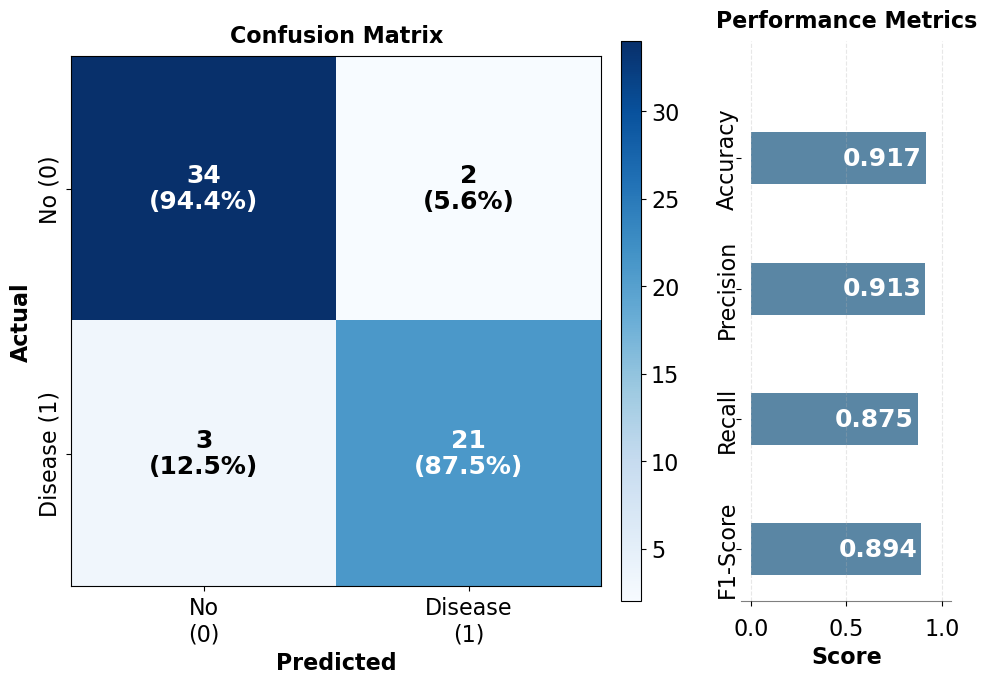

In [22]:
# Show SEL-NNML Evaluation Metrics
y_pred_stack = sel_nnml.predict(X_test)
evaluation_metrics_plot(y_test, y_pred_stack)

In [23]:
# Show SEL-NNM: all fold scores with mean and std 
sel_nnml_cv_scores = cross_val_score(sel_nnml, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=N_JOBS)
print(f'SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: {sel_nnml_cv_scores}')
print(f'Mean: {sel_nnml_cv_scores.mean():.4f}')
print(f'Standard Deviation: {sel_nnml_cv_scores.std():.4f}')

SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: [0.83333333 0.79166667 0.85106383 0.74468085 0.82978723]
Mean: 0.8101
Standard Deviation: 0.0380


In [24]:
# Show SELL-NNML Training Time
Total_training_time = base_models_training_time + meta_model_training_time
print(f'Base Models Tuning & Training Time: {base_models_training_time:.2f} seconds')
print(f'Meta Model Tuning & Training Time: {meta_model_training_time:.2f} seconds')
print(f'Total SEL-NNML Tuning & Training Time: {Total_training_time:.2f} seconds')

Base Models Tuning & Training Time: 56.07 seconds
Meta Model Tuning & Training Time: 75.93 seconds
Total SEL-NNML Tuning & Training Time: 132.00 seconds


### **6.2 Multiple Model Evaluation**

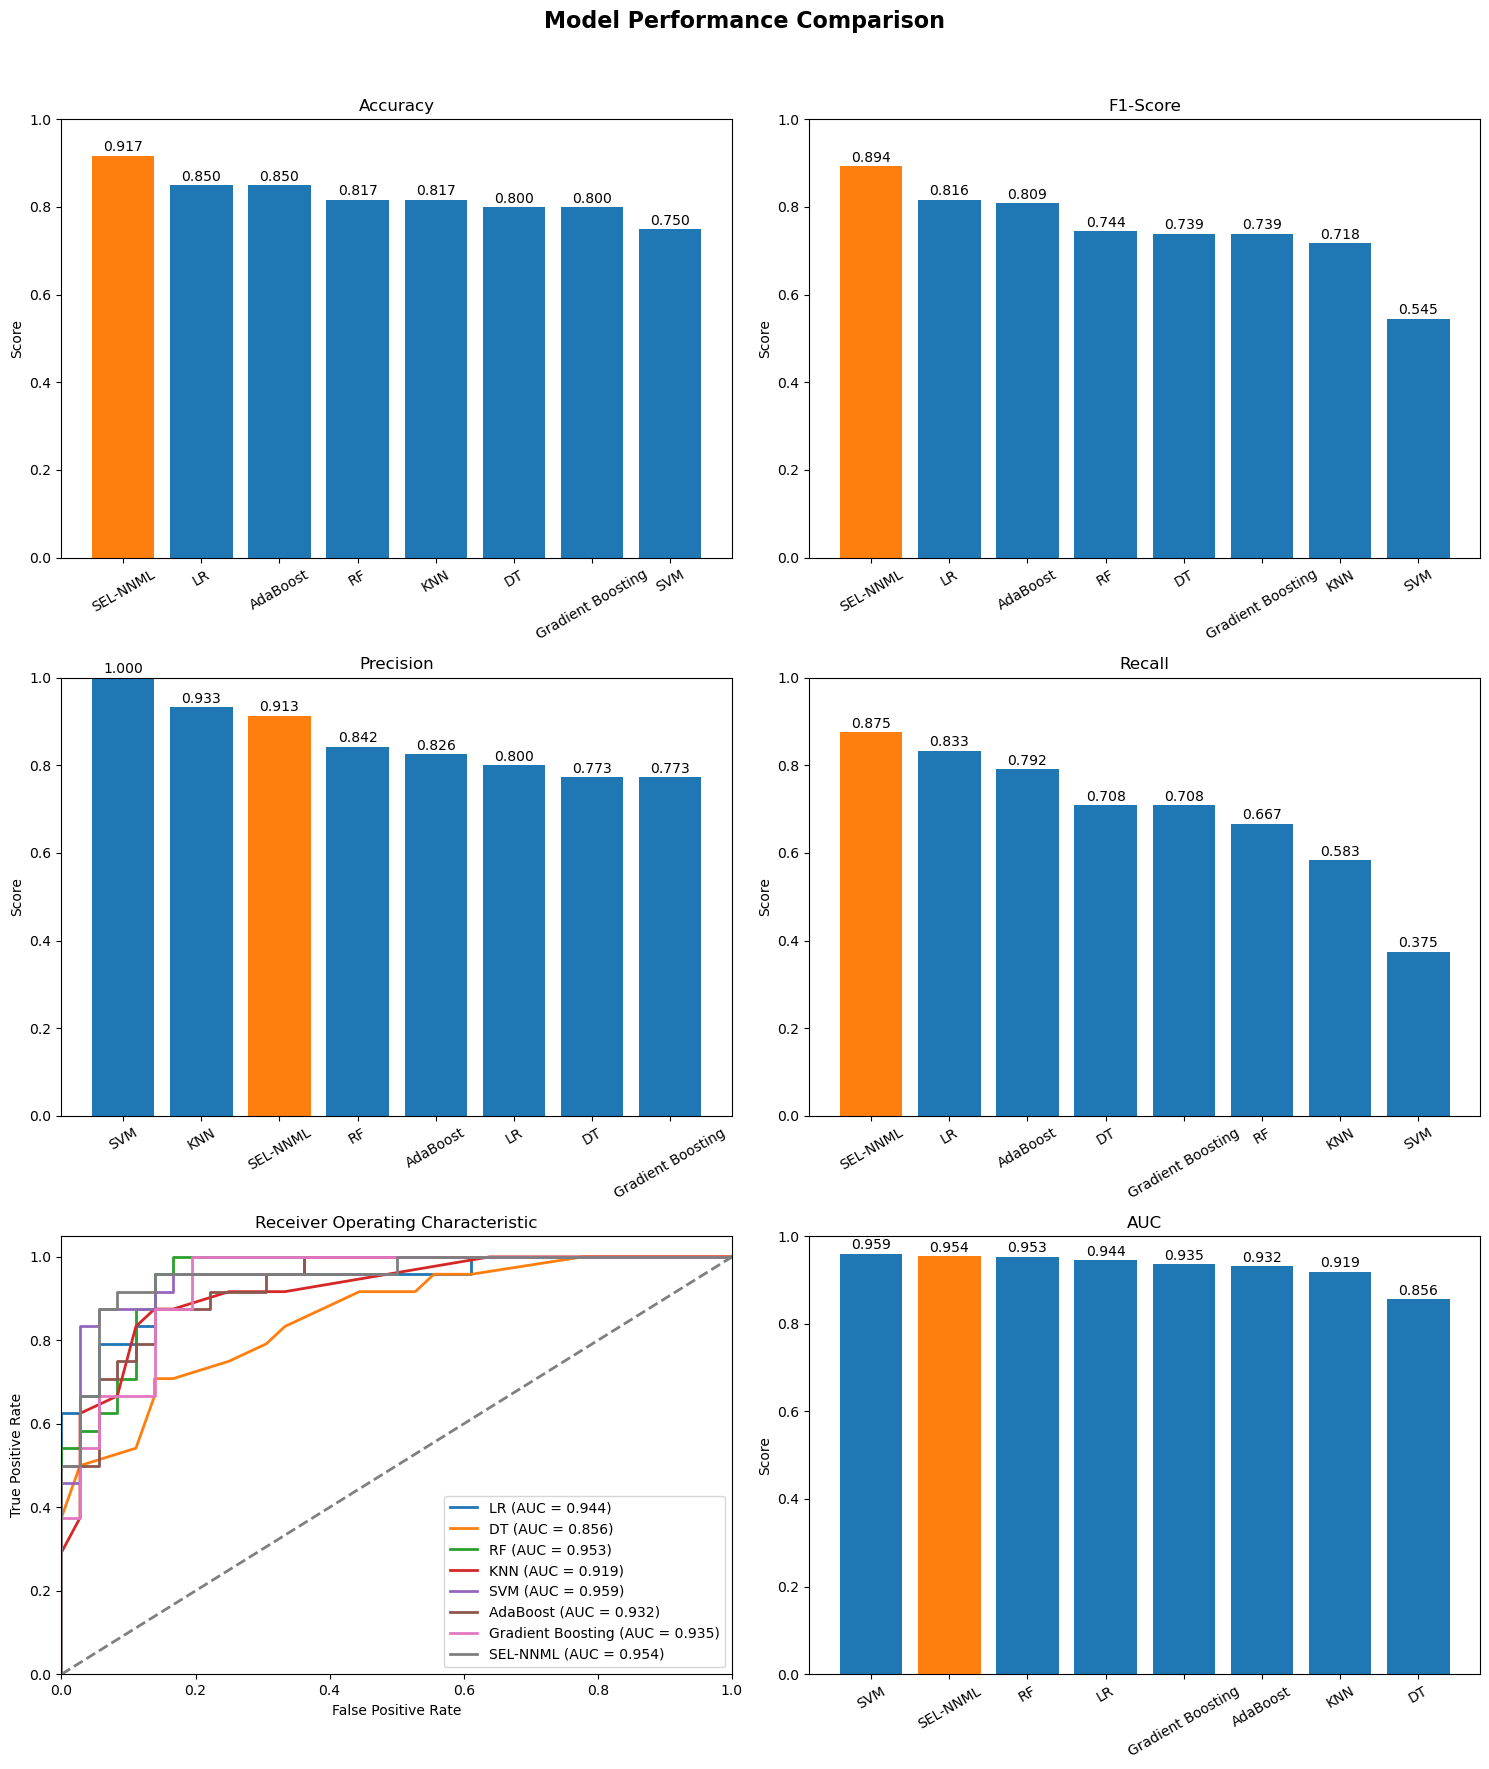

In [25]:
model_comparison_plot(all_models, X_test, y_test)

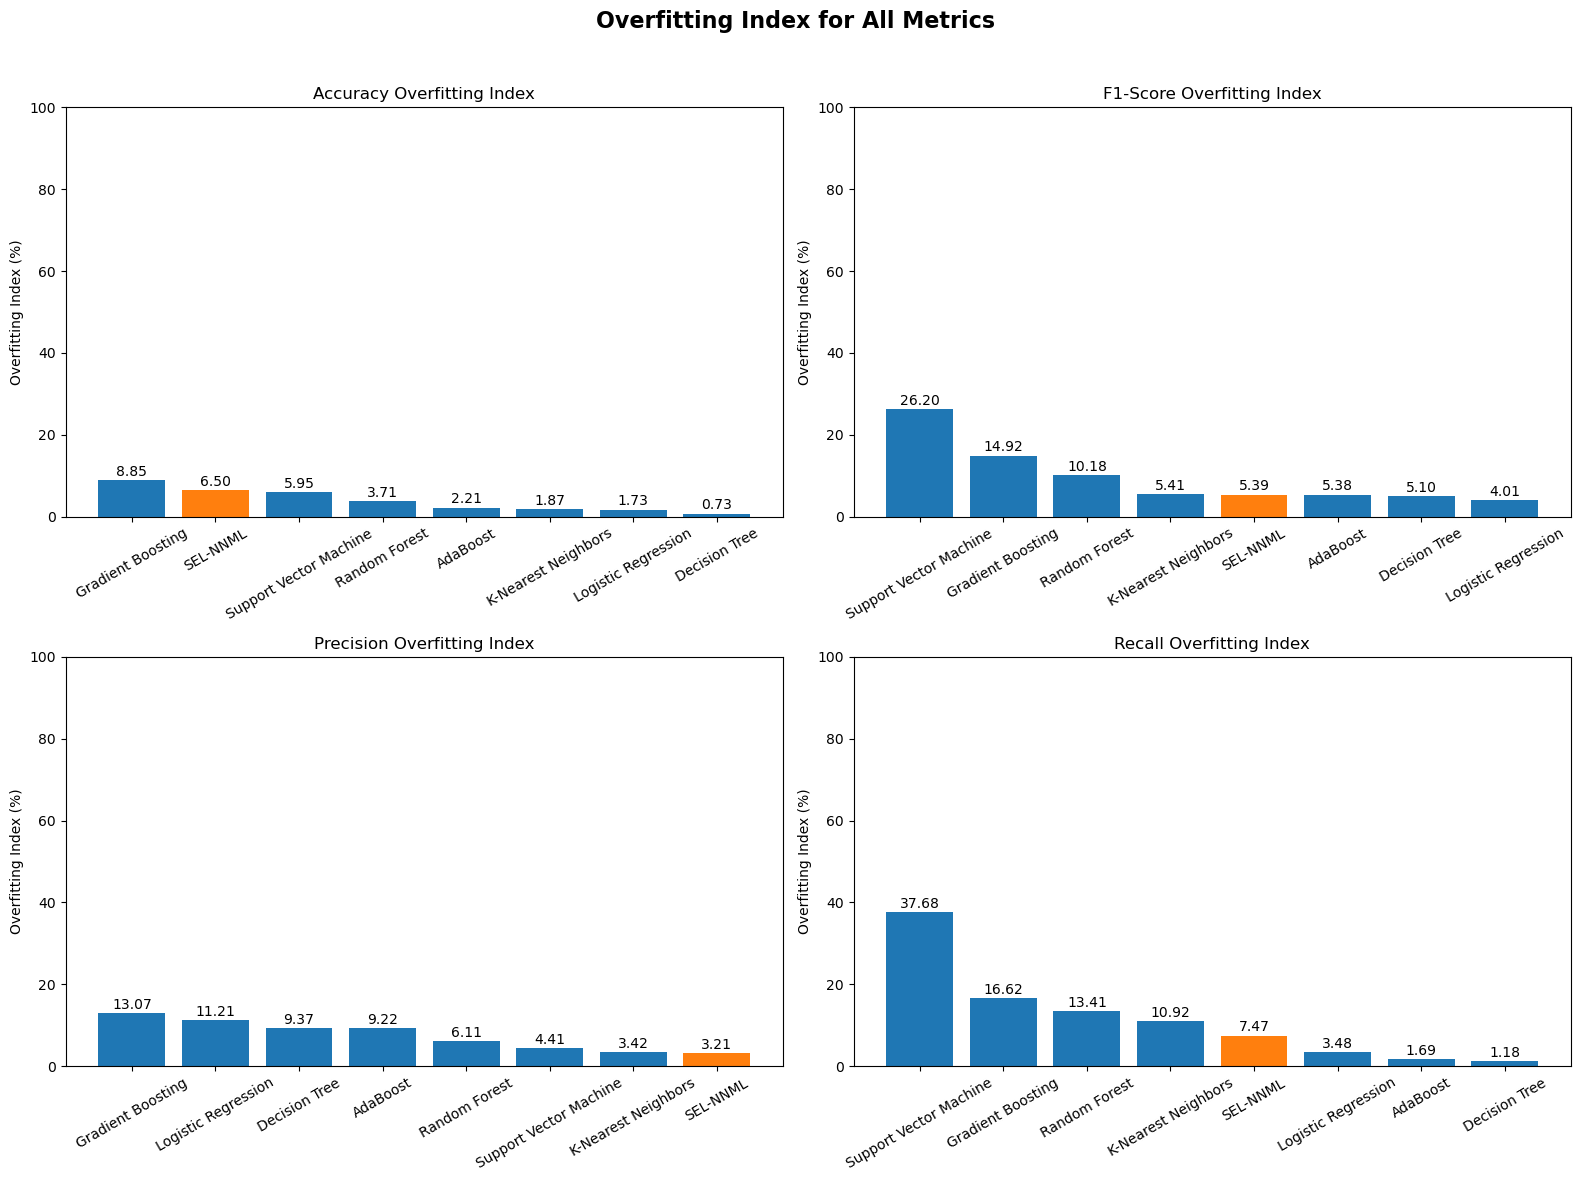

In [26]:
overfitting_index_plot(all_models, X_train, y_train, X_test, y_test)